In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import math
import sys
import re
import statistics
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import lightgbm as lgb
import simple_lightGBM

In [2]:
df = pd.read_csv('data/DDG_Dataset_dist_Kidera.csv')
df = df[df['TEMP'] != "'-"]
ndatas = df.shape[0]
print(df.columns)
df

Index(['ID', 'TEMP', 'pH', 'PDB', 'MUTATION', 'chain', 'ddG', 'A', 'R', 'N',
       'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T',
       'W', 'Y', 'V', 'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY',
       'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP',
       'TYR', 'VAL', 'Kidera_0', 'Kidera_1', 'Kidera_2', 'Kidera_3',
       'Kidera_4', 'Kidera_5', 'Kidera_6', 'Kidera_7', 'Kidera_8', 'Kidera_9'],
      dtype='object')


,ID,TEMP,pH,PDB,MUTATION,chain,ddG,A,R,N,...,Kidera_0,Kidera_1,Kidera_2,Kidera_3,Kidera_4,Kidera_5,Kidera_6,Kidera_7,Kidera_8,Kidera_9
0,13111,298.15,7.5,12CA,G145R,A,-0.360000,0.0,1.0,0.0,...,-1.585343,0.492594,0.661326,-1.242804,-0.365329,-1.352580,-0.629848,0.157755,0.552728,0.610638
1,13110,298.15,7.5,12CA,H94Y,A,-1.170000,0.0,0.0,0.0,...,-0.820398,0.015932,-0.396325,-0.651443,0.447063,-0.789494,-0.089048,0.811497,1.706994,-0.515717
2,8625,329.83,6.5,1A0F,S11A,A,-1.800000,1.0,0.0,0.0,...,0.060134,-1.311882,-0.178009,-0.744594,0.292331,-1.418528,0.248968,-0.555226,0.178872,0.672534
3,4405,303.15,7.0,1A23,P151A,A,-3.019013,1.0,0.0,0.0,...,-0.498620,-0.490843,-0.182037,-1.393750,0.303348,0.058314,0.246750,0.264783,1.079031,0.366582
4,3661,303.15,6.3,1A23,H32S,A,-5.200000,0.0,0.0,0.0,...,0.829904,-0.040843,0.022546,-1.418299,0.406216,0.076213,0.958939,-1.097800,1.455064,-0.256101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7984,11815,278.15,7.0,5TR5,I44A,A,-1.148325,1.0,0.0,0.0,...,-0.840592,-0.307056,0.772631,0.042227,0.181924,-0.699600,-0.292672,0.762266,0.122844,0.704220
7985,11320,298.15,8.0,5VP3,R39K,A,0.413480,0.0,-1.0,0.0,...,0.195955,0.991407,0.012329,-0.041153,-0.266360,-0.789183,0.482266,0.269042,0.462153,0.195984
7986,11321,298.15,8.0,5VP3,S128G,A,-0.377629,0.0,0.0,0.0,...,-0.884315,0.336544,0.560522,-1.068174,-1.068412,-1.967318,-0.015810,0.189277,0.834460,0.325178
7987,11322,298.15,8.0,5VP3,V183T,A,0.353728,0.0,0.0,0.0,...,-0.194854,-0.126772,-0.116993,0.058190,-0.796814,-0.899134,-0.464923,-0.519305,0.777412,0.083511


In [3]:
res_three = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 
             'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 
             'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
kidera_factors = ['Kidera_0', 'Kidera_1', 'Kidera_2', 'Kidera_3', 'Kidera_4', 
                  'Kidera_5', 'Kidera_6', 'Kidera_7', 'Kidera_8', 'Kidera_9']

In [4]:
# df['Temperature'] = df['Temperature'].astype('float64')
df['TEMP'] = df['TEMP'].astype('float64')
# print(df['Temperature'].unique())
data_df = df.drop(columns=['ID', 'MUTATION', 'chain', 'PDB', 'ddG'])
data_df = data_df.drop(columns=res_three)
# data_df = data_df.drop(columns=kidera_factors)
data_x = data_df.to_numpy()
data_y = df['ddG'].to_numpy()

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
pred_y = np.zeros(ndatas)
feature_importance = np.zeros(data_x.shape[1])
for index, (train_indices, valid_indices) in enumerate(kf.split(range(ndatas))):
    print(index)
    print(train_indices)
    print(valid_indices)
    train_x, test_x = data_x[train_indices], data_x[valid_indices] 
    train_y = data_y[train_indices]
    pred_y[valid_indices], importances = simple_lightGBM.predict(train_x, train_y, test_x)
    feature_importance += importances

0
[   0    2    3 ... 7986 7987 7988]
[   1    5    6 ... 7964 7974 7978]
1
[   1    3    4 ... 7986 7987 7988]
[   0    2   11 ... 7969 7970 7976]
2
[   0    1    2 ... 7983 7984 7987]
[  12   13   24 ... 7985 7986 7988]
3
[   0    1    2 ... 7986 7987 7988]
[   4   17   18 ... 7961 7971 7983]
4
[   0    1    2 ... 7985 7986 7988]
[   3    7   10 ... 7981 7984 7987]


In [6]:
df['pred_ddG'] = pred_y
df.to_csv('data/pred_DDG_Dataset_dist_Kidera_lightGBM.csv', index=False)

In [7]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(df['ddG'], df['pred_ddG']))

2.4585556354478366


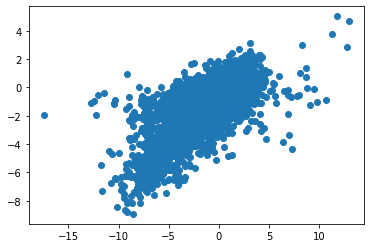

In [8]:
plt.scatter(df['ddG'], df['pred_ddG'])

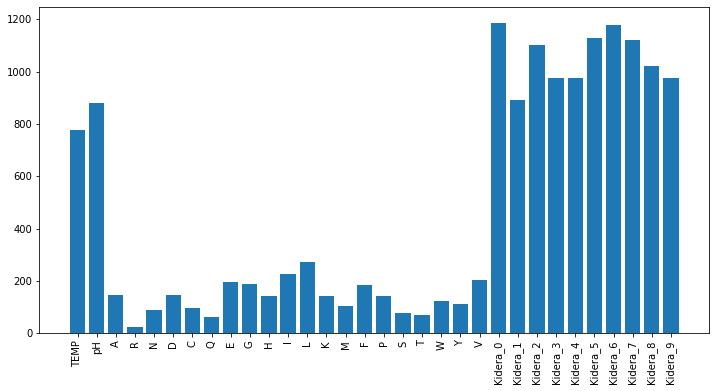

In [9]:
plt.figure(figsize=(12.0, 6.0))
plt.bar(data_df.columns, feature_importance)
plt.xticks(rotation=90)
plt.show()